In [1]:
!gdown "https://drive.google.com/u/0/uc?id=1Ce9EfcikQohU-WIp1Mb1YyIRrZQPby5C&confirm=t"
import shutil
shutil.unpack_archive("/content/CNN_dataset.zip", "/content/CNN_dataset")

Downloading...
From: https://drive.google.com/u/0/uc?id=1Ce9EfcikQohU-WIp1Mb1YyIRrZQPby5C&confirm=t
To: /content/CNN_dataset.zip
100% 100M/100M [00:00<00:00, 177MB/s] 


In [2]:
!ls /content/CNN_dataset/CNN_dataset/AbdomenCT -1 | wc -l

10000


In [3]:
from sklearn.model_selection import train_test_split
import os
import shutil

# Define the path to the dataset
data_dir = '/content/CNN_dataset/CNN_dataset'

# Define the parameters for the ImageDataGenerator
batch_size = 32
img_height = 64
img_width = 64

# Create a list of all the image file paths and their corresponding labels
file_paths = []
labels = []
for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if not os.path.isdir(label_dir): continue
    for img_file in os.listdir(label_dir):
        img_path = os.path.join(label_dir, img_file)
        file_paths.append(img_path)
        labels.append(label)

# Split the dataset into training and test sets
train_file_paths, test_file_paths, train_labels, test_labels = train_test_split(
    file_paths,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# Split the training set into training and validation sets
train_file_paths, val_file_paths, train_labels, val_labels = train_test_split(
    train_file_paths,
    train_labels,
    test_size=0.25,
    random_state=42,
    stratify=train_labels
)

# Create directories for the training, validation, and test sets
train_dir = '/content/train'
val_dir = '/content/val'
test_dir = '/content/test'
for dir_name in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
# Copy the training/validation/testing images to the training directory
for paths, labels, dir in [(train_file_paths, train_labels, train_dir), (val_file_paths, val_labels, val_dir), (test_file_paths, test_labels, test_dir)]:
    for file_path, label in zip(paths, labels):
        img_file = os.path.basename(file_path)
        label_dir = os.path.join(dir, label)
        if not os.path.exists(label_dir):
            os.makedirs(label_dir)
        shutil.copyfile(file_path, os.path.join(label_dir, img_file))
# print number of file in train AbdomenCT
! ls /content/train/AbdomenCT -1 | wc -l

6000


In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential

# Define the data generators
train_dir = '/content/train'
val_dir = '/content/val'
test_dir = '/content/test'

# Define the image size
img_size = (64, 64)

# Define the batch size
batch_size = 256

# Create the data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)
num_classes = 5
# Define the model architecture
model = tf.keras.models.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# # Define the model architecture
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(num_classes, activation='softmax')
# ])

# # Compile the model
# model.compile(
#     loss='categorical_crossentropy',
#     optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
#     metrics=['accuracy']
# )
epochs = 10
# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

# Save the model
model.save('/content/cnn_classification_model.h5')


Found 30000 images belonging to 5 classes.
Found 10000 images belonging to 5 classes.
Found 10000 images belonging to 5 classes.


Epoch 1/10


938/938 [==============================] - 171s 167ms/step - loss: 0.1493 - accuracy: 0.9451 - val_loss: 0.0514 - val_accuracy: 0.9845
Epoch 2/10
938/938 [==============================] - 155s 165ms/step - loss: 0.0359 - accuracy: 0.9880 - val_loss: 0.0041 - val_accuracy: 0.9988
Epoch 3/10
938/938 [==============================] - 156s 166ms/step - loss: 0.0303 - accuracy: 0.9902 - val_loss: 0.0030 - val_accuracy: 0.9994
Epoch 4/10
938/938 [==============================] - 155s 165ms/step - loss: 0.0164 - accuracy: 0.9950 - val_loss: 0.0031 - val_accuracy: 0.9991
Epoch 5/10
938/938 [==============================] - 156s 167ms/step - loss: 0.0178 - accuracy: 0.9939 - val_loss: 0.0051 - val_accuracy: 0.9981
Epoch 6/10
938/938 [==============================] - 158s 168ms/step - loss: 0.0181 - accuracy: 0.9943 - val_loss: 0.0054 - val_accuracy: 0.9983
Epoch 7/10
938/938 [==============================] - 157s 167ms/step - loss: 0.0082 - accuracy: 0.9974 - val_loss: 0.0013 - val_accura

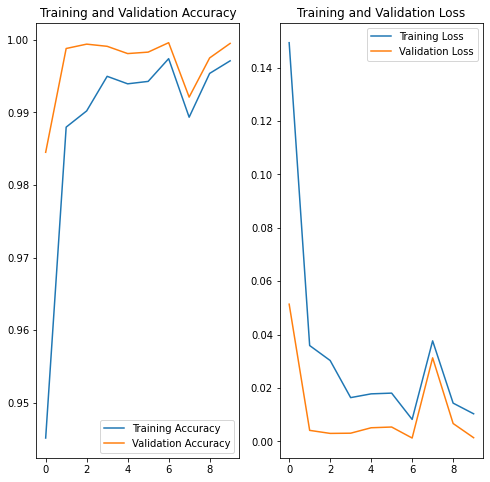

In [7]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10) # epochs

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Found 100 images belonging to 5 classes.
10/10 [==============================] - 0s 5ms/step


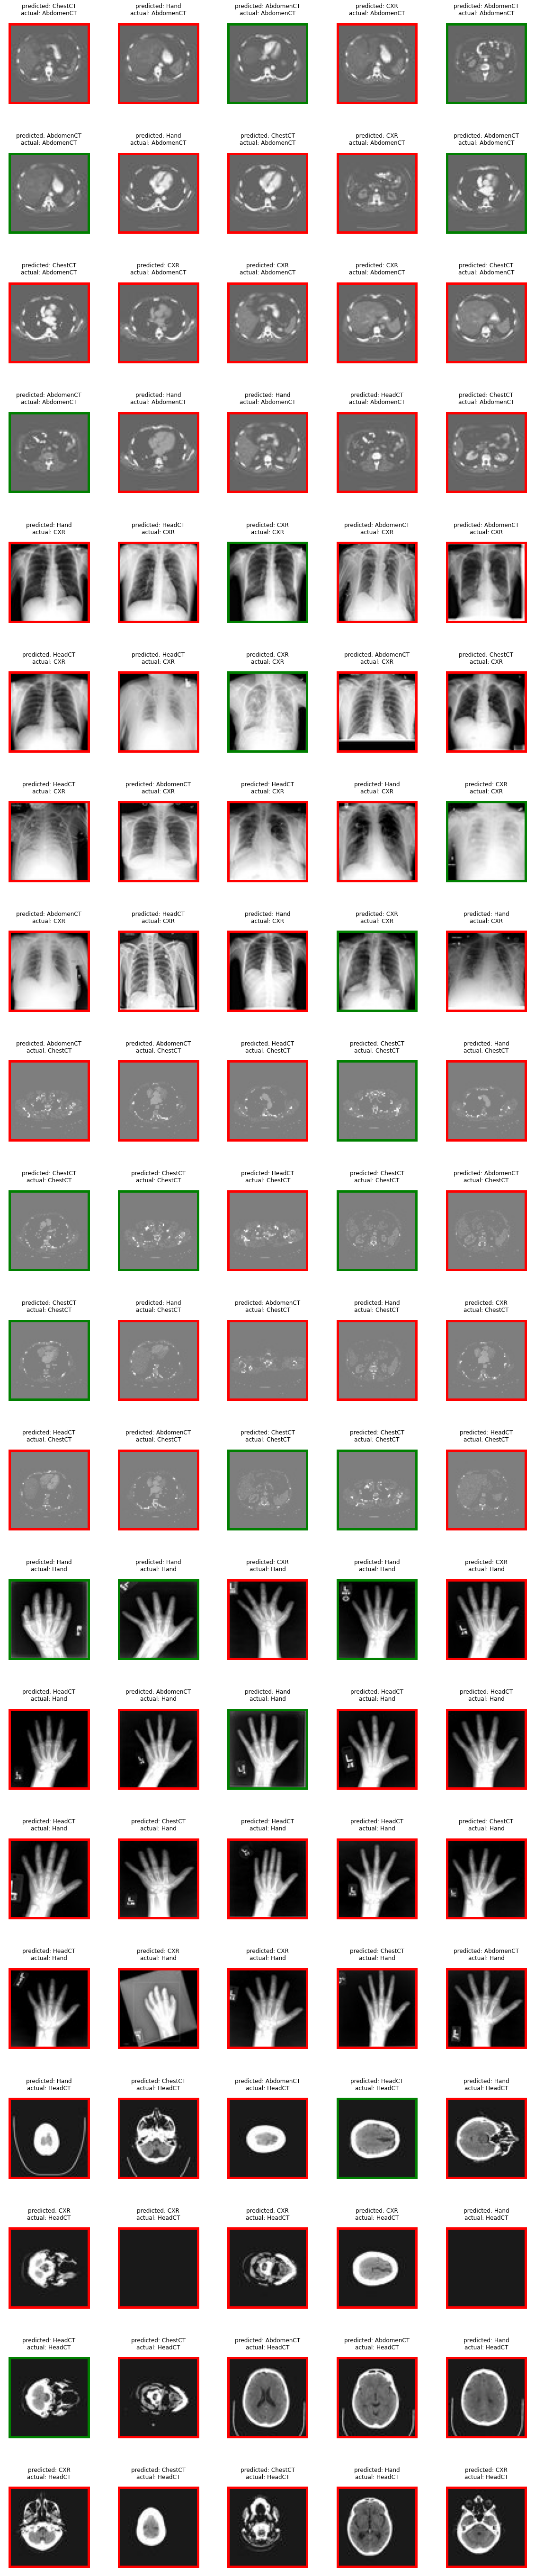

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
import tensorflow as tf
from matplotlib.patches import Rectangle

from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/content/cnn_classification_model.h5')

# Define the test data generator
test_datagen = image.ImageDataGenerator(rescale=1./255, validation_split=0.01)

# Define the test dataset directory and batch size
test_dir = '/content/test'
batch_size = 10
image_size = (64, 64)
# Create the test data generator from the directory
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Make predictions on the test dataset
y_pred = model.predict(test_generator, steps=(test_generator.n + batch_size - 1) // batch_size)

# Get the predicted class labels for each image
predicted_classes = np.argmax(y_pred, axis=1)
predicted_class_labels = [class_labels[i] for i in predicted_classes]
actual_class_labels = [class_labels[i] for i in test_generator.classes]
# Get the filenames of the images in the test dataset
filenames = test_generator.filenames

# Display the images and their predicted labels
num_images = len(filenames)
cols = 5
rows = (num_images + cols - 1) // cols

fig, axs = plt.subplots(rows, cols, figsize=(20, 100))

for i in range(num_images):
    img_path = test_dir + '/' + filenames[i]
    img = tf.keras.utils.load_img(img_path, target_size=image_size)
    axs[i//cols, i%cols].add_patch(plt.Rectangle((0, 0), 64, 64, edgecolor= 'r' if predicted_class_labels[i] != actual_class_labels[i] else 'g', linewidth=5, facecolor='none'))
    axs[i//cols, i%cols].set_xlim(-5, 64+5)
    axs[i//cols, i%cols].set_ylim(64+5, -5)
    axs[i//cols, i%cols].imshow(img)
    axs[i//cols, i%cols].set_title(f'predicted: {predicted_class_labels[i]}\nactual: {actual_class_labels[i]}')
    axs[i//cols, i%cols].axis('off')
plt.show()
